In [69]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 22. Label Trick GNN Metrics 

For the model created in the last script, get predictions and metrics / performance information.  Focus on the unseen "test" data.  Use sklearn metrics to ensure comparability with XGBoost metrics

Implementation notes:
  * To visualize the keras model, I had to "conda install" pydot and graphviz in my virtual environment. 
  * Model is saved/loaded in tensorflow format.  This is to workaround an issue with Keras format, https://github.com/tensorflow/tensorflow/issues/46659

*This script takes about 2 hours on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np

In [3]:
from pathlib import Path
import importlib, pickle
from contextlib import redirect_stdout
from scikitplot.metrics import plot_lift_curve
import matplotlib.pyplot as plt

In [4]:
from stellargraph import StellarGraph
import stellargraph as sg
import keras
from stellargraph.layer import HinSAGE, MeanHinAggregator
from stellargraph.mapper import HinSAGENodeGenerator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import tensorflow.keras.metrics as km
from keras.utils import plot_model
from keras import initializers
import tensorflow as tf

2023-12-26 12:58:07.066449: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-26 12:58:07.066474: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-26 12:58:07.066482: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-26 12:58:07.066516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-26 12:58:07.066534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
from sba_gnn.sba_gnn import sg_gnn, sg_plot 

## Import Data

##### Stellargraphs - all data, test only data

In [6]:
# All clients - focus on test metrics but other nodes needed for flow
with open(Path(setup.temp_path).joinpath('20_DATA_stellargraph_all.pkl'), 'rb') as fin:
      sba_all  = pickle.load(fin)

In [7]:
labels_all = pd.read_parquet(Path(setup.temp_path).joinpath('10_DATA_label_info.parquet'))

In [8]:
# Test only cases - expect much worse performance on this set
with open(Path(setup.temp_path).joinpath('20_DATA_stellargraph_test.pkl'), 'rb') as fin:
      sba_test  = pickle.load(fin)

In [9]:
labels_test = pd.read_parquet(Path(setup.temp_path).joinpath('11_DATA_labels_test.parquet'))

##### Model

In [11]:
model = keras.models.load_model(Path(setup.temp_path).joinpath('21_DATA_model.keras'),
                               safe_mode=False,
                               custom_objects={'MeanHinAggregator':MeanHinAggregator})

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Model Info
Print and save some information about the model layers (summary and plot)

In [12]:
with open(Path(setup.temp_path).joinpath('22_REPORT_model_summary.txt'), "w") as f:
    with redirect_stdout(f):
        print(model.summary())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 200, 11)]            0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 200, 11)]            0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 200, 11)]            0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 200, 11)]            0         []                            
                                                                                              

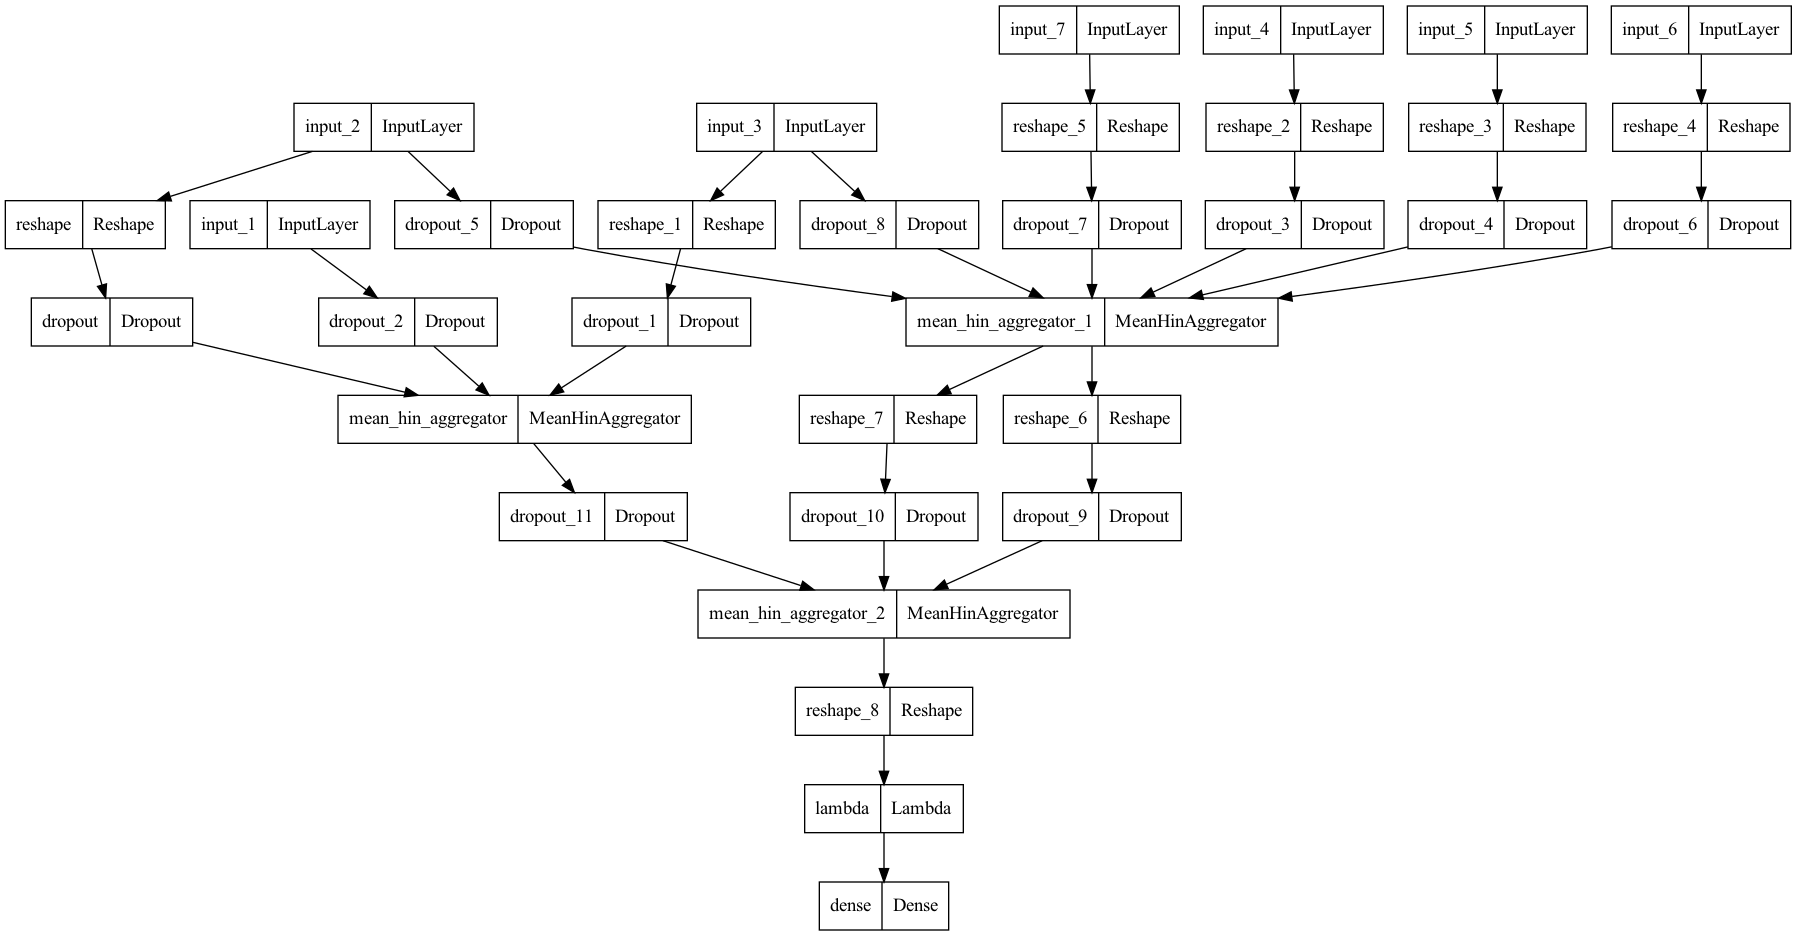

In [13]:
plot_model(model, Path(setup.temp_path).joinpath('22_model_plot_simp.png'))

The 2-hop model has three MeanHinAggregator layers, likely reflecting the 2 edge types.

In [14]:
%%capture
plot_model(model, to_file=Path(setup.temp_path).joinpath('22_model_plot_with_shapes.png'),
          show_shapes=True)

## Graph Containing All Nodes
Get predictions and metrics

##### Get generator and predict for all nodes (train, validation, test)

In [15]:
generator = HinSAGENodeGenerator(sba_all, batch_size=setup.gnn_batch_size, 
                                 num_samples=setup.gnn_num_samples, 
                                 head_node_type='LoanNr_ChkDgt',
                                 seed=34)

In [16]:
all_flow = generator.flow(labels_all.index, labels_all['target'], shuffle=False)

In [17]:
tf.random.set_seed(16)
keras.utils.set_random_seed(812)
sg.random.set_seed(4345)

In [18]:
all_predictions = model.predict(all_flow)

2023-12-26 13:00:44.392213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6881/6881 [==============================] - 4100s 596ms/step


In [19]:
all_predictions.shape

(688081, 1)

In [20]:
pd.Series(all_predictions[:,0], index=labels_all.index)

LoanNr_ChkDgt
5282874009    0.094068
2568556001    0.132672
2687465005    0.119729
9174473001    0.114811
3598634004    0.167767
                ...   
1533475000    0.274077
2597975001    0.304815
4381063007    0.139652
6010603003    0.107774
3215386008    0.195221
Length: 688081, dtype: float32

In [52]:
all_pred_df = pd.concat([pd.Series(all_predictions[:,0], index=labels_all.index).rename('predict_prob'),
                         labels_all], axis=1) \
    .reset_index()

In [53]:
all_pred_df.head(3)

,LoanNr_ChkDgt,predict_prob,dset,target,train_fix
0,5282874009,0.094068,train,0,0
1,2568556001,0.132672,train,0,0
2,2687465005,0.119729,train,1,0


## Threshold Tune & Binary Predictions
Using training probability predictions

In [54]:
all_pred_train = all_pred_df[all_pred_df['dset'] == 'train']

In [55]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [56]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
9,0.18,0.379451
8,0.16,0.378586
10,0.20,0.377338


In [57]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.18

##### Append binary predictions to probability predictions

In [58]:
all_pred_df['predict_bin'] = sg_plot.get_binary_predictions(all_pred_df['predict_prob'], best_thresh)

In [59]:
all_pred_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
1    0.59608
0    0.40392
Name: proportion, dtype: float64

In [60]:
#all_pred_df = all_pred_df.merge(labels_all.reset_index(), on='LoanNr_ChkDgt')

In [61]:
all_pred_df.to_parquet(Path(setup.temp_path).joinpath('22_DATA_predictions_all.parquet'))

In [62]:
all_pred_df.sample(3)

,LoanNr_ChkDgt,predict_prob,dset,target,train_fix,predict_bin
502508,7509974009,0.186718,test,1,0,1
12963,2056634005,0.055979,train,0,0,0
35411,6391724003,0.350651,train,0,0,1


In [63]:
pd.crosstab(all_pred_df['predict_bin'], all_pred_df['target'])

target,0,1
predict_bin,,
0,244034,33896
1,304359,105792


## Metrics

In [64]:
metrics_df = pd.concat([sg_plot.dset_metrics(all_pred_df[all_pred_df['dset'] == d]['target'], 
                                             all_pred_df[all_pred_df['dset'] == d]['predict_bin'], 
                                             all_pred_df[all_pred_df['dset'] == d]['predict_prob']) \
                        for d in ['train', 'val', 'test']], axis=1,
                      keys = ['train', 'val', 'test']) \
    .transpose()
metrics_df.to_csv(Path(setup.temp_path).joinpath('22_REPORT_metrics_all.csv'), index=True)
metrics_df

,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
train,0.518509,0.379451,0.256956,0.725134,0.259730,0.616241
val,0.489495,0.394434,0.259772,0.818981,0.308812,0.663976
test,0.489754,0.393681,0.259424,0.815954,0.304826,0.662265


## Lift

In [65]:
pred_test_df = all_pred_df[all_pred_df['dset'] == 'test']

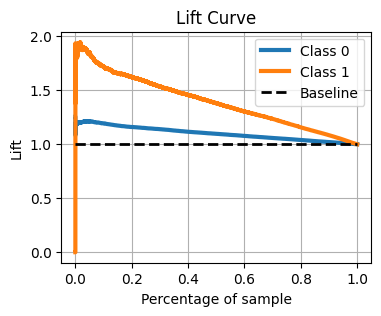

In [66]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('22_PLOT_lift_curve.png'),bbox_inches='tight')

## Embeddings
Extract node embeddings for businesses, and save these for later analysis

In [84]:
# Create a new model object to access the embeddings 1 layers above (normalized output)
emb_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [85]:
embeddings = emb_model.predict(all_flow)

2023-12-26 14:26:51.728922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6881/6881 [==============================] - 1761s 256ms/step


In [86]:
embeddings_df = pd.DataFrame(embeddings, index=labels_all.index)
embeddings_df.columns = [f'emb_{c:02d}' for c in embeddings_df.columns]

In [87]:
embeddings_df.describe()

,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,-0.321412,-0.314514,0.451864,0.040907,0.192623,-0.297783,0.034046,0.529606
std,0.131964,0.102195,0.098258,0.121440,0.209434,0.123068,0.238929,0.127059
min,-0.574167,-0.827171,-0.162290,-0.312936,-0.286633,-0.642889,-0.601282,0.115344
25%,-0.412060,-0.384280,0.399256,-0.029783,0.006666,-0.393490,-0.167095,0.431806
50%,-0.348424,-0.292824,0.456794,0.036161,0.185580,-0.308727,0.095882,0.549195
75%,-0.256704,-0.245969,0.519381,0.112507,0.352429,-0.198213,0.229045,0.628655
max,0.599875,0.087481,0.769601,0.512853,0.694026,0.035181,0.477351,0.824517


In [88]:
embeddings_df.to_parquet(Path(setup.temp_path).joinpath('22_DATA_embeddings.parquet'))

## Metrics on Test-Only Graph
Repeat metrics on the test nodes (and associated NAICS nodes) only.  Expect some performance degradation

In [70]:
generator_test = HinSAGENodeGenerator(sba_test, batch_size=setup.gnn_batch_size, 
                                 num_samples=setup.gnn_num_samples, 
                                 head_node_type='LoanNr_ChkDgt',
                                 seed=2343)

In [71]:
test_flow = generator_test.flow(labels_test['LoanNr_ChkDgt'], labels_test['target'], shuffle=False)

In [72]:
tf.random.set_seed(16)
keras.utils.set_random_seed(812)
sg.random.set_seed(4345)

In [73]:
test_predictions = model.predict(test_flow)

   1/7225 [..............................] - ETA: 27:01

2023-12-26 14:23:15.260826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7225/7225 [==============================] - 155s 21ms/step


In [74]:
test_predictions.shape

(144497, 1)

In [75]:
test_pred_df = pd.Series(test_predictions[:,0], index=labels_test['LoanNr_ChkDgt']) \
    .rename('predict_prob').reset_index()

In [76]:
test_pred_df.head(3)

,LoanNr_ChkDgt,predict_prob
0,8821253008,0.134117
1,3487724004,0.161867
2,3589114010,0.220331


In [77]:
test_pred_df['predict_bin'] = sg_plot.get_binary_predictions(test_pred_df['predict_prob'], best_thresh)

In [78]:
test_pred_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
1    0.776494
0    0.223506
Name: proportion, dtype: float64

In [79]:
test_pred_df = test_pred_df.merge(labels_test, on='LoanNr_ChkDgt')

In [80]:
test_pred_df.to_parquet(Path(setup.temp_path).joinpath('22_DATA_predictions_test_graph.parquet'))

##### Metrics - test only

In [81]:
test_metrics = sg_plot.dset_metrics(test_pred_df['target'],test_pred_df['predict_bin'], 
                                    test_pred_df['predict_prob'])
pd.DataFrame(test_metrics).transpose() \
    .to_csv(Path(setup.temp_path).joinpath('22_REPORT_metrics_test_only.csv'), index=True)
test_metrics

accuracy_score             0.388264
f1_score                   0.375466
precision_score            0.236816
recall_score               0.905778
average_precision_score    0.259523
roc_auc_score              0.623494
dtype: float64

##### Lift - test only

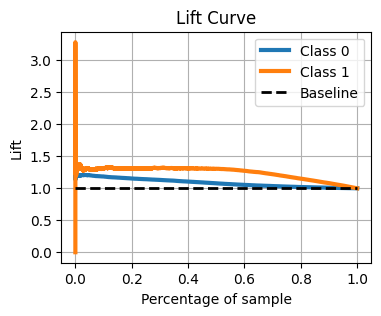

In [82]:
plot_lift_curve(test_pred_df['target'], 
                pd.concat([1-test_pred_df['predict_prob'], test_pred_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('22_PLOT_lift_curve_testonly.png'),bbox_inches='tight')